In [1]:
import ot
import numpy as np
import pandas as pd


import torch
import torch.nn as nn
import torch.optim as optim

import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

from ot import *

In [2]:
from torch.nn.utils.weight_norm import weight_norm

In [32]:

class FCNet(nn.Module):
    """Simple class for non-linear fully connect network
    """
    def __init__(self, dims, act='ReLU', dropout=0):
        super(FCNet, self).__init__()

        layers = []
        for i in range(len(dims)-2):
            in_dim = dims[i]
            out_dim = dims[i+1]
            if 0 < dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(weight_norm(nn.Linear(in_dim, out_dim), dim=None))
            if ''!=act:
                layers.append(getattr(nn, act)())
        if 0 < dropout:
            layers.append(nn.Dropout(dropout))
        layers.append(weight_norm(nn.Linear(dims[-2], dims[-1]), dim=None))
        if ''!=act:
            layers.append(getattr(nn, act)())

        self.main = nn.Sequential(*layers)

    def forward(self, x):
        return self.main(x)


In [33]:
class MLP(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        hidden1 = int(input_dim/2)
        hidden2 = int(input_dim/2)
        self.layer = torch.nn.Linear(input_dim, hidden1)    
        self.layer2 = torch.nn.Linear(hidden1, hidden2)    
        self.layer3 = torch.nn.Linear(hidden2, output_dim)     
        self.batchnorm1 = torch.nn.BatchNorm1d(hidden1)
        self.batchnorm2 = torch.nn.BatchNorm1d(hidden2)
    def forward(self, x):
        x = torch.relu(self.layer(x))
        x = self.batchnorm1(x)
        x = torch.relu(self.layer2(x))
        x = self.batchnorm2(x)
        outputs = torch.relu(self.layer3(x))
        return outputs

In [34]:
device = 'cuda:2'

In [35]:
# embedding_path = '/data/dahn017/KDD23/datasets/politifact/'
embedding_path = '/data/dahn017/KDD23/datasets/fakeddit/'

text_embed = np.load(f'{embedding_path}/pretrained/text_sbert_embeds.npy')
img_embed = np.load(f'{embedding_path}/pretrained/img_clip_embeds.npy')
print(text_embed.shape, img_embed.shape)

text_embed = np.nan_to_num(text_embed)
img_embed = np.nan_to_num(img_embed)
# text_embed = torch.FloatTensor(text_embed[:10]).to(device)
# img_embed = torch.FloatTensor(img_embed[:10]).to(device)
text_embed = torch.FloatTensor(text_embed).to(device)
img_embed = torch.FloatTensor(img_embed).to(device)

(13633, 768) (13633, 512)


In [36]:
N = text_embed.shape[0]
bs = 256
dim1 = text_embed.shape[-1]
dim2 = img_embed.shape[-1]
output_dim = 64
k = 2
act='ReLU'
# dropout = 0.3
dropout = 0

In [37]:
# h_out = 32
# h_dim = 32
# k = 3 # ?
# h_mat = nn.Parameter(torch.Tensor(1, output_dim * (k-2), 1, output_dim * (k-2)).normal_())
# h_bias = nn.Parameter(torch.Tensor(1, output_dim * (k-2), 1, 1).normal_())
# # h_net = weight_norm(nn.Linear(h_dim * self.k, h_out), dim=None)
# print(h_mat.shape, h_bias.shape)

In [52]:
device = 'cuda:2'
# mlp1 = FCNet([dim1, output_dim * k, output_dim * (k-2)], act=act, dropout=dropout).to(device)
# mlp2 = FCNet([dim2, output_dim * k, output_dim * (k-2)], act=act, dropout=dropout).to(device)
mlp1 = FCNet([dim1, output_dim * k], act=act, dropout=dropout).to(device)
mlp2 = FCNet([dim2, output_dim * k], act=act, dropout=dropout).to(device)

In [53]:
batchs = np.arange(bs, N, bs)

In [54]:
opt = optim.Adam(list(mlp1.parameters()) + list(mlp2.parameters()), lr=0.0001, weight_decay=0.001)

In [55]:
n_iter = 30

In [56]:
from tqdm import tqdm
from tqdm import trange

In [58]:

for i in range(1, n_iter):
    old_b = 0
    for batch in batchs:
        opt.zero_grad()
        loss = torch.zeros(1).to(device)
        batch_x = text_embed[old_b : batch]
        batch_y = img_embed[old_b : batch]
        x = mlp1(batch_x).reshape(-1, output_dim * (k), 1)
        y = mlp2(batch_y).reshape(-1, output_dim * (k), 1)

        cos_distance = cost_matrix_batch_torch(x.transpose(2, 1), y.transpose(2, 1))
        cos_distance = cos_distance.transpose(1,2)

        # logits = torch.einsum('xhyk,bvk,bqk->bhvq', (h_mat, x, y)) + h_bias

        beta = 0.1
        min_score = cos_distance.min()
        max_score = cos_distance.max()
        threshold = min_score + beta * (max_score - min_score)
        cos_dist = torch.nn.functional.relu(cos_distance - threshold)

        wd = - IPOT_distance_torch_batch_uniform(C=cos_dist, bs=x.size(0), n=x.size(1), m=y.size(1), iteration=30)
        gwd = GW_distance_uniform(x.transpose(2,1), y.transpose(2,1))

        # twd = .1 * torch.mean(gwd) + .1 * torch.mean(wd)
        twd = .5 * torch.sum(gwd) + .5 * torch.sum(wd)
        loss = loss + twd
        # loss = loss - torch.bmm(x.transpose(2,1), y).sum() * 0.01
        # loss = loss + torch.norm(x - y) * 0.1
        old_b = batch
        loss.backward()
        opt.step()
    print(f"Iteration {i} || alignment loss: {loss.item():.4f}")
    


Iteration 1 || alignment loss: 86.7258
Iteration 2 || alignment loss: 90.7499
Iteration 3 || alignment loss: 95.9050
Iteration 4 || alignment loss: 99.4334
Iteration 5 || alignment loss: 100.4883
Iteration 6 || alignment loss: 102.7552
Iteration 7 || alignment loss: 101.8100
Iteration 8 || alignment loss: 102.2064
Iteration 9 || alignment loss: 102.0032
Iteration 10 || alignment loss: 97.4733
Iteration 11 || alignment loss: 99.9248
Iteration 12 || alignment loss: 95.2142
Iteration 13 || alignment loss: 98.0639
Iteration 14 || alignment loss: 99.8903
Iteration 15 || alignment loss: 102.8307
Iteration 16 || alignment loss: 101.1977
Iteration 17 || alignment loss: 101.5341
Iteration 18 || alignment loss: 106.5417
Iteration 19 || alignment loss: 102.6024
Iteration 20 || alignment loss: 104.6160
Iteration 21 || alignment loss: 104.3327
Iteration 22 || alignment loss: 101.2290
Iteration 23 || alignment loss: 103.2335
Iteration 24 || alignment loss: 106.3114
Iteration 25 || alignment loss: 10

In [44]:
y_all = np.load(f'{embedding_path}/y_all.npy')[:10]
# y_all = np.load(f'{embedding_path}/y_all.npy')

In [45]:
x = mlp1(text_embed)[:10]
y = mlp2(img_embed)[:10]
# x = mlp1(text_embed)
# y = mlp2(img_embed)

In [46]:
fake = y_all == 0
true = y_all == 1

In [47]:
sorted_x = np.vstack([x[true].cpu().detach().numpy(), x[fake].cpu().detach().numpy()])
sorted_y = np.vstack([y[true].cpu().detach().numpy(), y[fake].cpu().detach().numpy()])

In [48]:
# text_embed2 = np.vstack([text_embed[true].cpu().detach().numpy(), text_embed[fake].cpu().detach().numpy()])
# img_embed2 = np.vstack([img_embed[true].cpu().detach().numpy(), img_embed[fake].cpu().detach().numpy()])
# 
text_embed2 = np.vstack([text_embed[:10][true].cpu().detach().numpy(), text_embed[:10][fake].cpu().detach().numpy()])
img_embed2 = np.vstack([img_embed[:10][true].cpu().detach().numpy(), img_embed[:10][fake].cpu().detach().numpy()])

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot: >

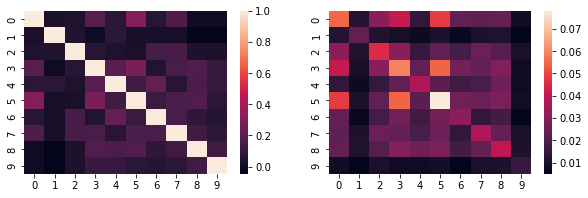

In [50]:
plt.figure(figsize=(10,3))
plt.subplot(1, 2, 1)
sns.heatmap((text_embed2 @ text_embed2.T))
plt.subplot(1, 2, 2)
sns.heatmap((sorted_x @ sorted_x.T))

<AxesSubplot: >

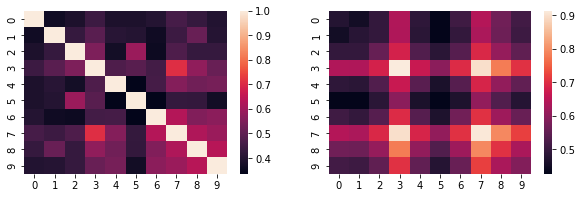

In [51]:
plt.figure(figsize=(10,3))
plt.subplot(1, 2, 1)
sns.heatmap((img_embed2 @ img_embed2.T))
plt.subplot(1, 2, 2)
# sns.heatmap((sorted_y / sorted_y @ sorted_y.T))
sns.heatmap((sorted_y @ sorted_y.T))

In [71]:
np.save(f'../outputs/got_text_sbert.npy', x.cpu().detach().numpy()  @ x.cpu().detach().numpy().T )
np.save(f'../outputs/got_img_clip.npy', y.cpu().detach().numpy() @ y.cpu().detach().numpy().T)

In [72]:
graph1 = np.load(graph_file1)
graph2 = np.load(graph_file2)

NameError: name 'graph_file1' is not defined

In [ ]:
# graph_file1 = f'./aligned_embeds/text_sbert.npy'
# graph_file2 = f'./aligned_embeds/img_clip.npy'
graph_file1 = f'./aligned_embeds/text_sbert_no.npy'
graph_file2 = f'./aligned_embeds/img_clip_no.npy'